In [1]:
import math
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
import itertools

from torch.autograd import Variable
from torch.cuda import FloatTensor
from torch.utils.data.dataloader import DataLoader
from torchvision import transforms
from torchvision.utils import save_image
from IPython.display import clear_output
from PIL import Image
from sklearn.preprocessing import OneHotEncoder

%matplotlib inline

## Load and transform data set

In [2]:
root_dir = "train"

train_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
#     transforms.RandomAffine(degrees=30),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )    
])

In [3]:
train_dataset = torchvision.datasets.ImageFolder(root=root_dir, 
                                             transform=train_transform)

In [4]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [5]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


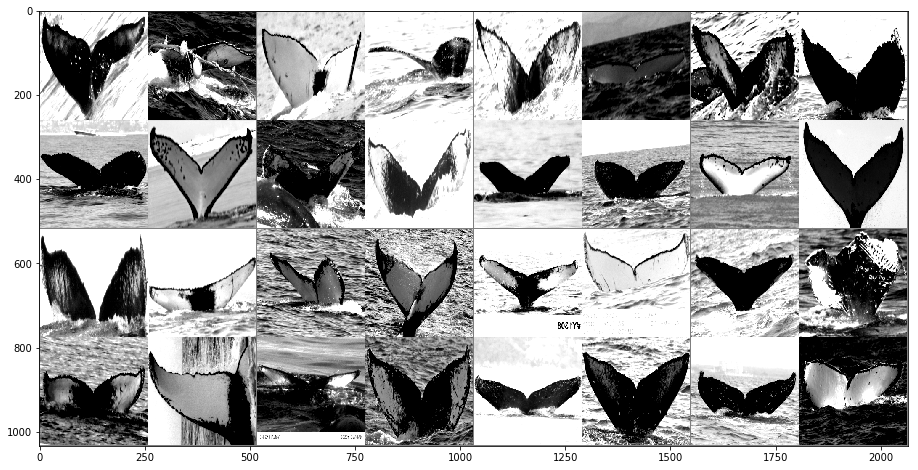

In [6]:
fig, axes = plt.subplots(figsize=(20, 8))

def imshow(x):
    x = x / 2 + 0.5     
    x = x.numpy()
    x = np.transpose(x, (1, 2, 0))
    plt.imshow(x)
       
imshow(torchvision.utils.make_grid(images))

## Adversarial Autoencoder (AAE)

In [9]:
latent_dim = 10
img_shape = (1, 256, 256)

Function for sample from latent space

In [10]:
def reparameterization(mu, logvar):
    std = torch.exp(logvar / 2)
    sampled_z = torch.autograd.Variable(torch.cuda.FloatTensor(np.random.normal(0, 1, (mu.size(0), latent_dim))))
    z = sampled_z * std + mu
    return z

### Define autoencoder 

In [11]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        self.mu = nn.Linear(512, latent_dim)
        self.logvar = nn.Linear(512, latent_dim)
        
    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        x = self.model(img_flat)
        mu = self.mu(x)
        logvar = self.logvar(x)
        z = reparameterization(mu, logvar)
        return z
    
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, int(np.prod(img_shape))),
            nn.Tanh()
        )
        
    def forward(self, z):
        img_flat = self.model(z)
        img = img_flat.view(img_flat.shape[0], *img_shape)
        return img

### Define Discriminator

In [12]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
        
    def forward(self, z):
        validity = self.model(z)
        return validity

### Train

Define device

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
assert device.type == 'cuda'

print(torch.cuda.get_device_name(0))

GeForce GTX 1060


Use binary cross-entropy loss

In [14]:
# Use binary cross-entropy loss
adversarial_loss = torch.nn.BCELoss()
pixelwise_loss = torch.nn.L1Loss()

Initialize generator and discrimiator

In [15]:
encoder = Encoder().to(device)
decoder = Decoder().to(device)
discriminator = Discriminator().to(device)

Set optimizers

In [16]:
lr = 0.0002
betas = (0.5, 0.999)
optimizer_gen = optim.Adam(itertools.chain(encoder.parameters(), decoder.parameters()), 
                           lr=lr, betas=betas)
optimizer_dis = optim.Adam(discriminator.parameters(), lr=lr, betas=betas)

Helper function for sampling images

In [17]:
def sample_image(n_row, batches_done):
    z = torch.autograd.Variable(FloatTensor(np.random.normal(0, 1, (n_row**2, latent_dim))))
    gen_imgs = decoder(z)
    save_image(gen_imgs.data, 'images/%d.png' % batches_done, nrow=n_row, normalize=True)

Train function

In [ ]:
n_epochs = 200
sample_interval = 100
for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(train_loader):
        valid = Variable(FloatTensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)
        fake = Variable(FloatTensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)
        
        real_imgs = Variable(imgs.type(FloatTensor))
        
        # Train generator
        optimizer_gen.zero_grad()
        encoded_imgs = encoder(real_imgs)
        decoder_imgs = decoder(encoded_imgs)
        
        # Loss 
        gen_loss = 0.001 * adversarial_loss(discriminator(encoded_imgs), valid) 
        gen_loss += 0.999 * pixelwise_loss(decoder_imgs, real_imgs)
        
        gen_loss.backward()
        optimizer_gen.step()
        
        # Train discriminator 
        optimizer_dis.zero_grad()
        
        # Sample noise as discriminator ground truth
        z = Variable(FloatTensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))
        
        # Loss
        real_loss = adversarial_loss(discriminator(z), valid)
        fake_loss = adversarial_loss(discriminator(encoded_imgs.detach()), fake)
        dis_loss = 0.5 * (real_loss + fake_loss)
        dis_loss.backward()
        optimizer_dis.step()
        
        batches_done = epoch * len(train_loader) + i
        
        if batches_done % 50 == 0:
            print("[Epoch %d/%d] [Batch %d/%d] [Dis loss: %f] [Gen loss: %f]" % (epoch, n_epochs, i, len(train_loader),
                    dis_loss.item(), gen_loss.item()))
        
        
        if batches_done % sample_interval == 0:
            sample_image(n_row=10, batches_done=batches_done) 

[Epoch 0/200] [Batch 0/793] [Dis loss: 0.698024] [Gen loss: 1.001771]
[Epoch 0/200] [Batch 50/793] [Dis loss: 0.433978] [Gen loss: 0.742307]
